# Próba pierwsza (baza)

#### 1. Tworzenie ścieżek i sprawdzanie rozmiarów zbiorów danych

In [2]:
from pathlib import Path


train_val_data_path = Path().cwd() / "mri" / "Training"
test_data_path = Path().cwd() / "mri" / "Testing"

if train_val_data_path.exists() and test_data_path.exists():

    categories_paths = train_val_data_path.glob("*")
    categories = [category.name for category in categories_paths]
    
    print(f"Available categories: {categories}")

    train_imgs_paths = train_val_data_path.glob("*/*.jpg")
    test_imgs_paths = test_data_path.glob("*/*.jpg")

    train_imgs = [img.name for img in train_imgs_paths]
    test_imgs = [img.name for img in test_imgs_paths]

    print(f"\nThe size of the training and validation dataset: {len(train_imgs)}.")
    print(f"\nThe size of the test dataset: {len(test_imgs)}.")

else: 
    print("Paths do not exist.")

Available categories: ['glioma', 'meningioma', 'notumor', 'pituitary']

The size of the training and validation dataset: 5712.

The size of the test dataset: 1311.


#### 2. Transformacja danych (resize i tensor), wydobywanie kategorii

In [3]:
from torchvision import datasets, transforms


img_resizer = transforms.Resize([250, 250])
img_tensor = transforms.ToTensor()

img_transformer = transforms.Compose([img_resizer, img_tensor])

full_training_and_val_dataset_transformed = datasets.ImageFolder(root=train_val_data_path, transform=img_transformer)
full_test_dataset_transformed = datasets.ImageFolder(root=test_data_path, transform=img_transformer)

img, cat = full_training_and_val_dataset_transformed[0]
print("--Training and validation dataset--")
print(f"Shape: {img.shape}; Type: {type(img)}; Category: {cat}", end="\n\n")

img, cat = full_test_dataset_transformed[0]
print("--Testing dataset--")
print(f"Shape: {img.shape}; Type: {type(img)}; Category: {cat}")

--Training and validation dataset--
Shape: torch.Size([3, 250, 250]); Type: <class 'torch.Tensor'>; Category: 0

--Testing dataset--
Shape: torch.Size([3, 250, 250]); Type: <class 'torch.Tensor'>; Category: 0


#### 3. Podział na zbiór treningowy i walidacyjny (75/25)

In [4]:
import torch
from torch.utils.data import DataLoader, random_split

seed = torch.Generator().manual_seed(42)
train_data, val_data = random_split(full_training_and_val_dataset_transformed, [0.75, 0.25], generator=seed)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)  
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(full_test_dataset_transformed, batch_size=32, shuffle=False, pin_memory=True)

#### 4. Tworzenie architektury sieci podstawowej (2 warstwy konwolucyjne)

In [5]:
import torch.nn as nn


class AntiTumor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),

            nn.Linear(32 * 62 * 62, 128),
            nn.ReLU(),

            nn.Linear(128, 4)
            )
        
    def forward(self, x):
        return self.layers(x)

#### 5. Instancja modelu, przerzucanie obliczeń na GPU

In [6]:
model = AntiTumor()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Model utilizes: {str(device).upper()}.")

model.to(device);

Model utilizes: CUDA.


#### 6. Funkcja straty i ADAM

In [7]:
import torch.optim as optim


loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### 7. Pętla treningowa i wykres uczenia

Epoch: [1/10] | Average Loss: 0.6590.
Epoch: [2/10] | Average Loss: 0.3438.
Epoch: [3/10] | Average Loss: 0.1968.
Epoch: [4/10] | Average Loss: 0.1078.
Epoch: [5/10] | Average Loss: 0.0589.
Epoch: [6/10] | Average Loss: 0.0341.
Epoch: [7/10] | Average Loss: 0.0180.
Epoch: [8/10] | Average Loss: 0.0182.
Epoch: [9/10] | Average Loss: 0.0024.
Epoch: [10/10] | Average Loss: 0.0005.

Training completed in 0:03:19.


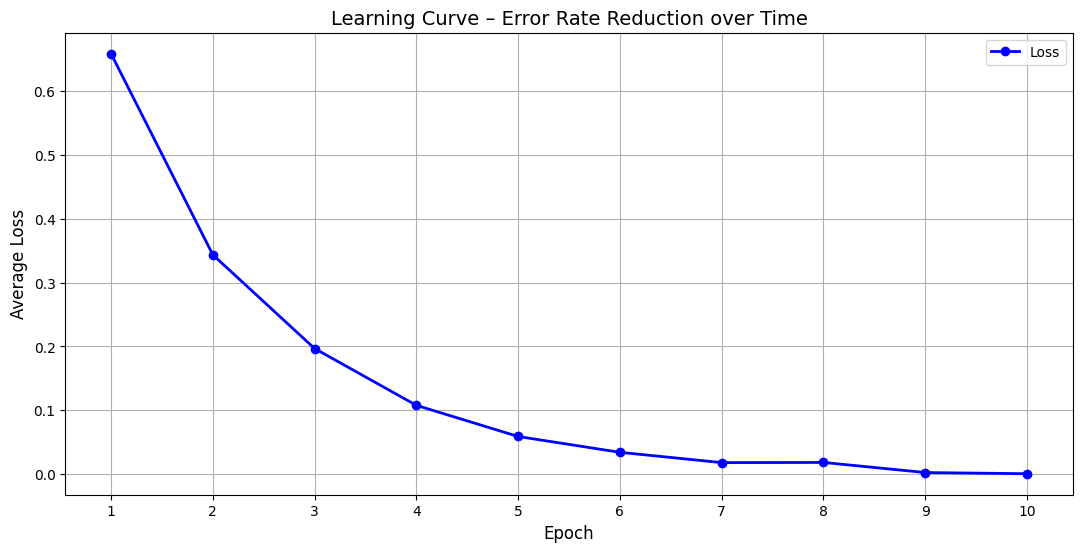

In [8]:
import matplotlib.pyplot as plt
import time
import datetime

epochs = 10

epochs_data = [epoch for epoch in range(1, epochs+1)]
avg_loss_data = []

train_start_time = time.time()

for epoch in range(epochs):
    running_loss = 0.0
    model.train()

    for img, category in train_loader:
        img, category = img.to(device), category.to(device)

        optimizer.zero_grad()

        outputs = model(img)

        loss = loss_func(outputs, category)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    avg_loss_data.append(avg_loss)

    print(f"Epoch: [{epoch+1}/{epochs}] | Average Loss: {avg_loss:.4f}.")

if torch.cuda.is_available():
    torch.cuda.synchronize()

train_stop_time = time.time()
train_total_secodns = train_stop_time - train_start_time

print(F"\nTraining completed in {datetime.timedelta(seconds=int(train_total_secodns))}.")



plt.figure(figsize=(13, 6))

plt.plot(epochs_data, avg_loss_data, 'o-', color='blue', label='Loss', linewidth=2)

plt.title('Learning Curve – Error Rate Reduction over Time', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.xticks(epochs_data)
plt.grid(True, linestyle='-')
plt.legend()

plt.show()

#### 8. Metryki

In [9]:
from sklearn.metrics import classification_report, confusion_matrix


y_true_val = []
y_pred_val = []

model.eval()

with torch.no_grad():
    for img, category in val_loader:
        img = img.to(device)

        results = model(img)
        results_list, result = torch.max(results, 1)

        y_true_val.extend(category)
        y_pred_val.extend(result.cpu().numpy())


y_true_test = []
y_pred_test = []

with torch.no_grad():
    for img, category in test_loader:
        img = img.to(device)

        results = model(img)
        results_list, result = torch.max(results, 1)

        y_true_test.extend(category)
        y_pred_test.extend(result.cpu().numpy())

print("------------------- Validation Set -------------------")
print(classification_report(y_true_val, y_pred_val, target_names=full_training_and_val_dataset_transformed.classes))

print("---------------------- Test Set ----------------------")
print(classification_report(y_true_test, y_pred_test, target_names=full_test_dataset_transformed.classes))


------------------- Validation Set -------------------
              precision    recall  f1-score   support

      glioma       0.93      0.91      0.92       329
  meningioma       0.87      0.88      0.87       334
     notumor       0.97      0.96      0.97       398
   pituitary       0.96      0.99      0.97       367

    accuracy                           0.93      1428
   macro avg       0.93      0.93      0.93      1428
weighted avg       0.93      0.93      0.93      1428

---------------------- Test Set ----------------------
              precision    recall  f1-score   support

      glioma       0.93      0.89      0.91       300
  meningioma       0.88      0.87      0.88       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.96      0.99      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



#### 9. Macierze pomyłek

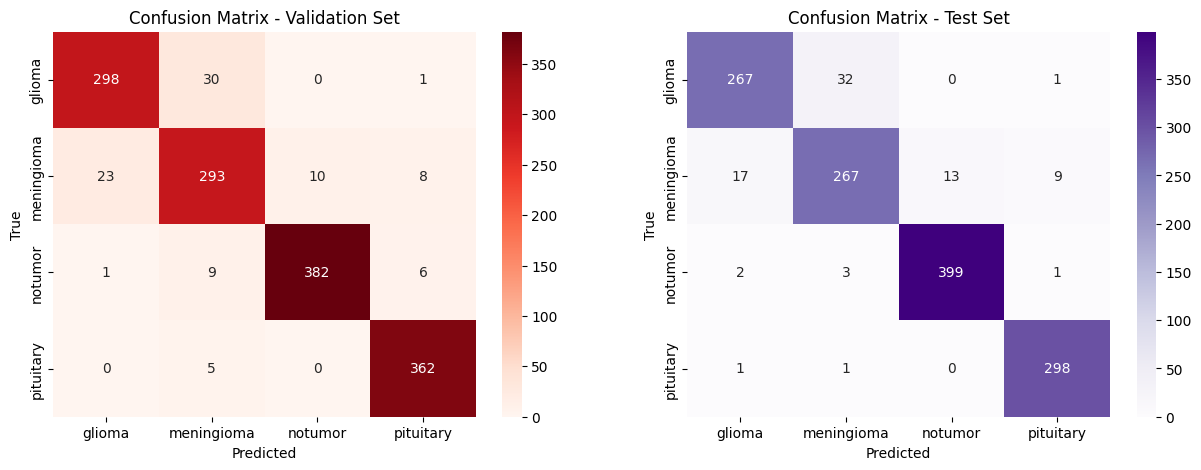

In [10]:
import seaborn as sns


cm_val = confusion_matrix(y_true_val, y_pred_val)
cm_test = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Reds',
            xticklabels=full_training_and_val_dataset_transformed.classes, 
            yticklabels=full_training_and_val_dataset_transformed.classes)

plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(122)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Purples',
            xticklabels=full_test_dataset_transformed.classes, 
            yticklabels=full_test_dataset_transformed.classes)

plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

### **WNIOSKI**: 
* #### Wysokie Accuracy, Precision i Recall dla każdego przypadku;
* #### Model ma największy problem z odróżnieniem oponiaka od glejaka (32 razy pomyliła glejaka z oponiakiem i 17 razy oponiaka z glejakiem na zbiorze testowym).

# Próba druga: zwiększenie rozmiarów zdjęć (250x250 do 500x500)

In [12]:
img_resizer = transforms.Resize([500, 500])
img_tensor = transforms.ToTensor()

img_transformer = transforms.Compose([img_resizer, img_tensor])

full_training_and_val_dataset_transformed = datasets.ImageFolder(root=train_val_data_path, transform=img_transformer)
full_test_dataset_transformed = datasets.ImageFolder(root=test_data_path, transform=img_transformer)

img, cat = full_training_and_val_dataset_transformed[0]
print("--Training and validation dataset--")
print(f"Shape: {img.shape}; Type: {type(img)}; Category: {cat}", end="\n\n")

img, cat = full_test_dataset_transformed[0]
print("--Testing dataset--")
print(f"Shape: {img.shape}; Type: {type(img)}; Category: {cat}")

--Training and validation dataset--
Shape: torch.Size([3, 500, 500]); Type: <class 'torch.Tensor'>; Category: 0

--Testing dataset--
Shape: torch.Size([3, 500, 500]); Type: <class 'torch.Tensor'>; Category: 0


In [13]:
seed = torch.Generator().manual_seed(42)
train_data, val_data = random_split(full_training_and_val_dataset_transformed, [0.75, 0.25], generator=seed)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)  
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(full_test_dataset_transformed, batch_size=32, shuffle=False, pin_memory=True)

In [18]:
class AntiTumor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),

            nn.Linear(32 * 125 * 125, 128),
            nn.ReLU(),

            nn.Linear(128, 4)
            )
        
    def forward(self, x):
        return self.layers(x)

In [19]:
model = AntiTumor()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Model utilizes: {str(device).upper()}.")

model.to(device);

Model utilizes: CUDA.


In [20]:
import torch.optim as optim


loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch: [1/10] | Average Loss: 0.8673.
Epoch: [2/10] | Average Loss: 0.3079.
Epoch: [3/10] | Average Loss: 0.1384.
Epoch: [4/10] | Average Loss: 0.0731.
Epoch: [5/10] | Average Loss: 0.0257.
Epoch: [6/10] | Average Loss: 0.0067.
Epoch: [7/10] | Average Loss: 0.0104.
Epoch: [8/10] | Average Loss: 0.0195.
Epoch: [9/10] | Average Loss: 0.0364.
Epoch: [10/10] | Average Loss: 0.0087.

Training completed in 0:17:17.


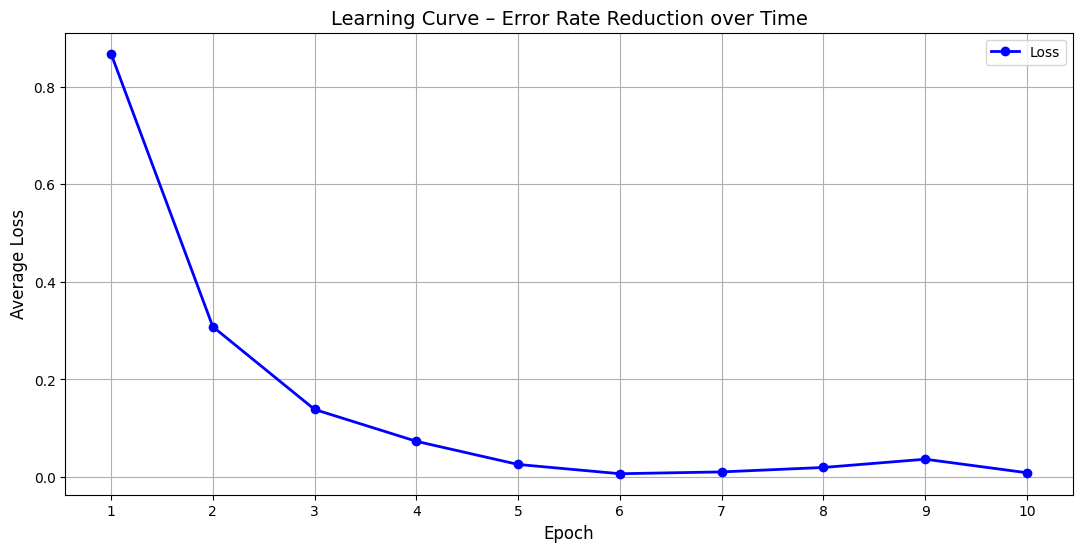

In [21]:
epochs = 10

epochs_data = [epoch for epoch in range(1, epochs+1)]
avg_loss_data = []

train_start_time = time.time()

for epoch in range(epochs):
    running_loss = 0.0
    model.train()

    for img, category in train_loader:
        img, category = img.to(device), category.to(device)

        optimizer.zero_grad()

        outputs = model(img)

        loss = loss_func(outputs, category)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    avg_loss_data.append(avg_loss)

    print(f"Epoch: [{epoch+1}/{epochs}] | Average Loss: {avg_loss:.4f}.")

if torch.cuda.is_available():
    torch.cuda.synchronize()

train_stop_time = time.time()
train_total_secodns = train_stop_time - train_start_time

print(F"\nTraining completed in {datetime.timedelta(seconds=int(train_total_secodns))}.")



plt.figure(figsize=(13, 6))

plt.plot(epochs_data, avg_loss_data, 'o-', color='blue', label='Loss', linewidth=2)

plt.title('Learning Curve – Error Rate Reduction over Time', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.xticks(epochs_data)
plt.grid(True, linestyle='-')
plt.legend()

plt.show()

In [22]:
y_true_val = []
y_pred_val = []

model.eval()

with torch.no_grad():
    for img, category in val_loader:
        img = img.to(device)

        results = model(img)
        results_list, result = torch.max(results, 1)

        y_true_val.extend(category)
        y_pred_val.extend(result.cpu().numpy())


y_true_test = []
y_pred_test = []

with torch.no_grad():
    for img, category in test_loader:
        img = img.to(device)

        results = model(img)
        results_list, result = torch.max(results, 1)

        y_true_test.extend(category)
        y_pred_test.extend(result.cpu().numpy())

print("------------------- Validation Set -------------------")
print(classification_report(y_true_val, y_pred_val, target_names=full_training_and_val_dataset_transformed.classes))

print("---------------------- Test Set ----------------------")
print(classification_report(y_true_test, y_pred_test, target_names=full_test_dataset_transformed.classes))

------------------- Validation Set -------------------
              precision    recall  f1-score   support

      glioma       0.94      0.92      0.93       329
  meningioma       0.83      0.91      0.87       334
     notumor       0.98      0.92      0.95       398
   pituitary       0.96      0.97      0.97       367

    accuracy                           0.93      1428
   macro avg       0.93      0.93      0.93      1428
weighted avg       0.93      0.93      0.93      1428

---------------------- Test Set ----------------------
              precision    recall  f1-score   support

      glioma       0.94      0.88      0.91       300
  meningioma       0.83      0.90      0.86       306
     notumor       0.98      0.96      0.97       405
   pituitary       0.96      0.96      0.96       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



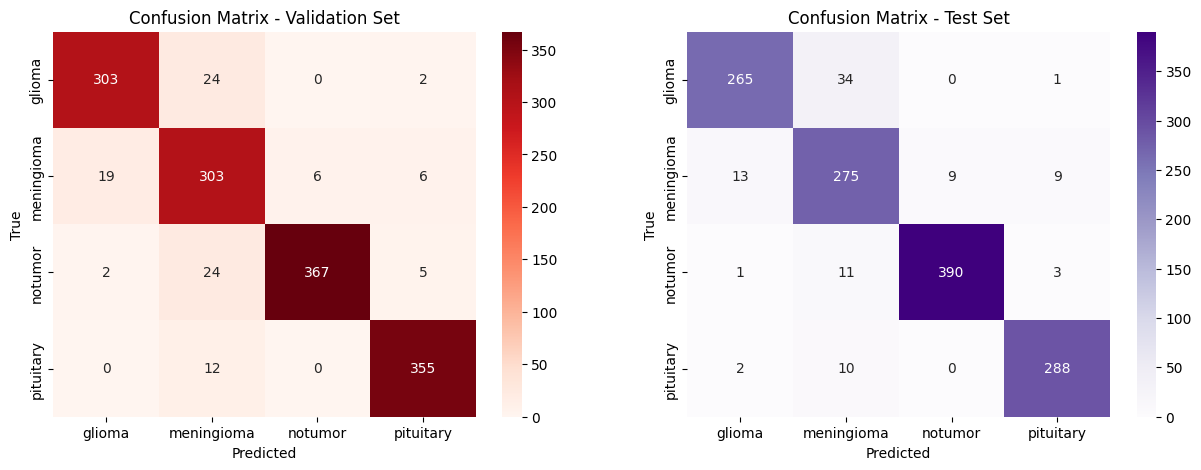

In [23]:
cm_val = confusion_matrix(y_true_val, y_pred_val)
cm_test = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Reds',
            xticklabels=full_training_and_val_dataset_transformed.classes, 
            yticklabels=full_training_and_val_dataset_transformed.classes)

plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(122)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Purples',
            xticklabels=full_test_dataset_transformed.classes, 
            yticklabels=full_test_dataset_transformed.classes)

plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

### **WNIOSKI**: 
* #### Nadal wysokie Accuracy, Precision i Recall dla każdego przypadku;
* #### Duży wzrost czasu treningu sieci;
* #### Model ogólnie pogorszył swoje przewidywania, najprawdopodobniej przez to, że rozmiar filtra został niezmieniony, natomiast musiał przetworzyć więcej informacji (wzrost mapy cech z 62 na 125), co przekłada się na uczenie większych detali zamiast ogólnych kształtów guzów.

# Próba trzecia: zmiana kolorystyki obrazów (jasność i kontrast)

In [51]:
img_resizer = transforms.Resize([250, 250])
img_color = transforms.ColorJitter(brightness=0.3, contrast=0.3)
img_tensor = transforms.ToTensor()

img_transformer = transforms.Compose([img_resizer, img_color, img_tensor])

full_training_and_val_dataset_transformed = datasets.ImageFolder(root=train_val_data_path, transform=img_transformer)
full_test_dataset_transformed = datasets.ImageFolder(root=test_data_path, transform=img_transformer)

img, cat = full_training_and_val_dataset_transformed[0]
print("--Training and validation dataset--")
print(f"Shape: {img.shape}; Type: {type(img)}; Category: {cat}", end="\n\n")

img, cat = full_test_dataset_transformed[0]
print("--Testing dataset--")
print(f"Shape: {img.shape}; Type: {type(img)}; Category: {cat}")

--Training and validation dataset--
Shape: torch.Size([3, 250, 250]); Type: <class 'torch.Tensor'>; Category: 0

--Testing dataset--
Shape: torch.Size([3, 250, 250]); Type: <class 'torch.Tensor'>; Category: 0


In [52]:
seed = torch.Generator().manual_seed(42)
train_data, val_data = random_split(full_training_and_val_dataset_transformed, [0.75, 0.25], generator=seed)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)  
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(full_test_dataset_transformed, batch_size=32, shuffle=False, pin_memory=True)

In [53]:
class AntiTumor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),

            nn.Linear(32 * 62 * 62, 128),
            nn.ReLU(),

            nn.Linear(128, 4)
            )
        
    def forward(self, x):
        return self.layers(x)

In [54]:
model = AntiTumor()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Model utilizes: {str(device).upper()}.")

model.to(device);

Model utilizes: CUDA.


In [55]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch: [1/10] | Average Loss: 0.9108.
Epoch: [2/10] | Average Loss: 0.5071.
Epoch: [3/10] | Average Loss: 0.3634.
Epoch: [4/10] | Average Loss: 0.2431.
Epoch: [5/10] | Average Loss: 0.1580.
Epoch: [6/10] | Average Loss: 0.1041.
Epoch: [7/10] | Average Loss: 0.0637.
Epoch: [8/10] | Average Loss: 0.0326.
Epoch: [9/10] | Average Loss: 0.0304.
Epoch: [10/10] | Average Loss: 0.0183.

Training completed in 0:04:44.


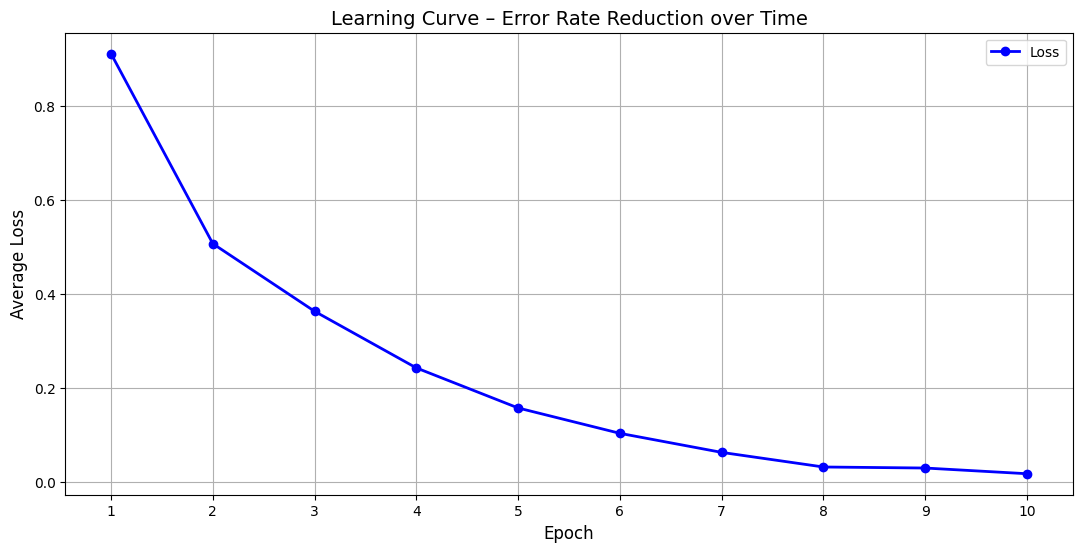

In [56]:
epochs = 10

epochs_data = [epoch for epoch in range(1, epochs+1)]
avg_loss_data = []

train_start_time = time.time()

for epoch in range(epochs):
    running_loss = 0.0
    model.train()

    for img, category in train_loader:
        img, category = img.to(device), category.to(device)

        optimizer.zero_grad()

        outputs = model(img)

        loss = loss_func(outputs, category)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    avg_loss_data.append(avg_loss)

    print(f"Epoch: [{epoch+1}/{epochs}] | Average Loss: {avg_loss:.4f}.")

if torch.cuda.is_available():
    torch.cuda.synchronize()

train_stop_time = time.time()
train_total_secodns = train_stop_time - train_start_time

print(F"\nTraining completed in {datetime.timedelta(seconds=int(train_total_secodns))}.")



plt.figure(figsize=(13, 6))

plt.plot(epochs_data, avg_loss_data, 'o-', color='blue', label='Loss', linewidth=2)

plt.title('Learning Curve – Error Rate Reduction over Time', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.xticks(epochs_data)
plt.grid(True, linestyle='-')
plt.legend()

plt.show()

In [57]:
y_true_val = []
y_pred_val = []

model.eval()

with torch.no_grad():
    for img, category in val_loader:
        img = img.to(device)

        results = model(img)
        results_list, result = torch.max(results, 1)

        y_true_val.extend(category)
        y_pred_val.extend(result.cpu().numpy())


y_true_test = []
y_pred_test = []

with torch.no_grad():
    for img, category in test_loader:
        img = img.to(device)

        results = model(img)
        results_list, result = torch.max(results, 1)

        y_true_test.extend(category)
        y_pred_test.extend(result.cpu().numpy())

print("------------------- Validation Set -------------------")
print(classification_report(y_true_val, y_pred_val, target_names=full_training_and_val_dataset_transformed.classes))

print("---------------------- Test Set ----------------------")
print(classification_report(y_true_test, y_pred_test, target_names=full_test_dataset_transformed.classes))


------------------- Validation Set -------------------
              precision    recall  f1-score   support

      glioma       0.86      0.91      0.89       329
  meningioma       0.88      0.78      0.82       334
     notumor       0.96      0.96      0.96       398
   pituitary       0.93      0.99      0.96       367

    accuracy                           0.91      1428
   macro avg       0.91      0.91      0.91      1428
weighted avg       0.91      0.91      0.91      1428

---------------------- Test Set ----------------------
              precision    recall  f1-score   support

      glioma       0.86      0.89      0.88       300
  meningioma       0.90      0.77      0.83       306
     notumor       0.96      0.99      0.97       405
   pituitary       0.93      1.00      0.96       300

    accuracy                           0.92      1311
   macro avg       0.91      0.91      0.91      1311
weighted avg       0.92      0.92      0.92      1311



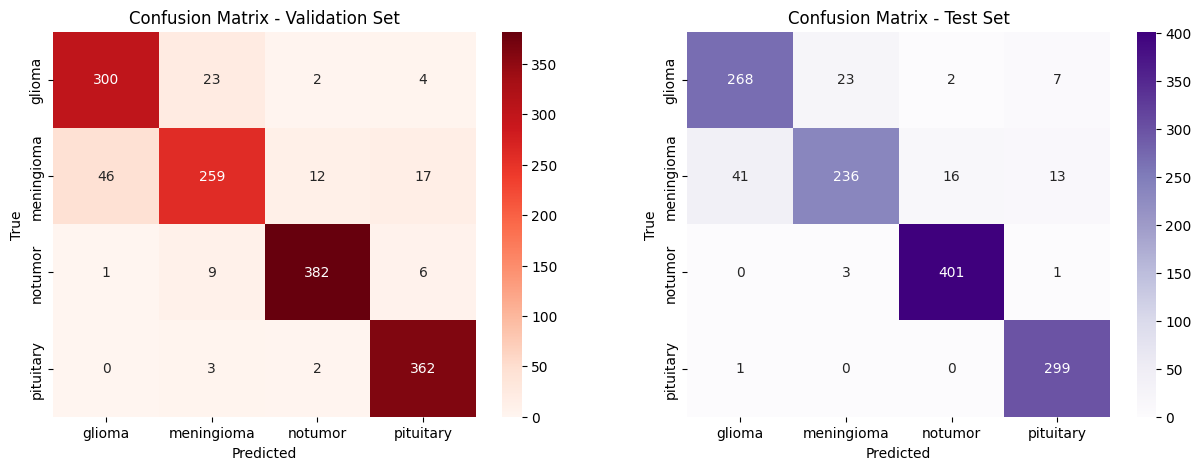

In [58]:
cm_val = confusion_matrix(y_true_val, y_pred_val)
cm_test = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Reds',
            xticklabels=full_training_and_val_dataset_transformed.classes, 
            yticklabels=full_training_and_val_dataset_transformed.classes)

plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(122)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Purples',
            xticklabels=full_test_dataset_transformed.classes, 
            yticklabels=full_test_dataset_transformed.classes)

plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

### **WNIOSKI**:
* #### Zmiana jasności i kontrastu również pogorszyła wyniki ze względu na zaburzenie tekstury guza na zdjęciach

# Próba czwarta: zmiana architektury sieci (dodatkowa warstwa konwolucyjna i zwiększona ilość filtrów)

In [67]:
img_resizer = transforms.Resize([250, 250])
img_tensor = transforms.ToTensor()

img_transformer = transforms.Compose([img_resizer, img_tensor])

full_training_and_val_dataset_transformed = datasets.ImageFolder(root=train_val_data_path, transform=img_transformer)
full_test_dataset_transformed = datasets.ImageFolder(root=test_data_path, transform=img_transformer)

img, cat = full_training_and_val_dataset_transformed[0]
print("--Training and validation dataset--")
print(f"Shape: {img.shape}; Type: {type(img)}; Category: {cat}", end="\n\n")

img, cat = full_test_dataset_transformed[0]
print("--Testing dataset--")
print(f"Shape: {img.shape}; Type: {type(img)}; Category: {cat}")

--Training and validation dataset--
Shape: torch.Size([3, 250, 250]); Type: <class 'torch.Tensor'>; Category: 0

--Testing dataset--
Shape: torch.Size([3, 250, 250]); Type: <class 'torch.Tensor'>; Category: 0


In [68]:
seed = torch.Generator().manual_seed(42)
train_data, val_data = random_split(full_training_and_val_dataset_transformed, [0.75, 0.25], generator=seed)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)  
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(full_test_dataset_transformed, batch_size=32, shuffle=False, pin_memory=True)

In [69]:
class AntiTumor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),

            nn.Linear(64 * 31 * 31, 128),
            nn.ReLU(),

            nn.Linear(128, 4)
            )
        
    def forward(self, x):
        return self.layers(x)

In [70]:
model = AntiTumor()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Model utilizes: {str(device).upper()}.")

model.to(device);

Model utilizes: CUDA.


In [71]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch: [1/10] | Average Loss: 0.7879.
Epoch: [2/10] | Average Loss: 0.4176.
Epoch: [3/10] | Average Loss: 0.2826.
Epoch: [4/10] | Average Loss: 0.1868.
Epoch: [5/10] | Average Loss: 0.1292.
Epoch: [6/10] | Average Loss: 0.0935.
Epoch: [7/10] | Average Loss: 0.0524.
Epoch: [8/10] | Average Loss: 0.0393.
Epoch: [9/10] | Average Loss: 0.0358.
Epoch: [10/10] | Average Loss: 0.0169.

Training completed in 0:03:36.


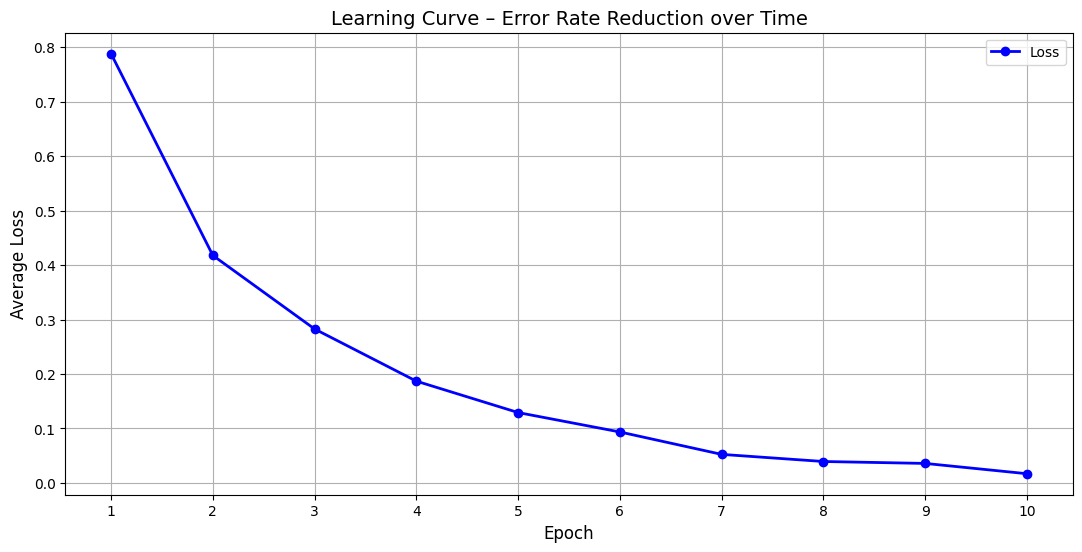

In [72]:
epochs = 10

epochs_data = [epoch for epoch in range(1, epochs+1)]
avg_loss_data = []

train_start_time = time.time()

for epoch in range(epochs):
    running_loss = 0.0
    model.train()

    for img, category in train_loader:
        img, category = img.to(device), category.to(device)

        optimizer.zero_grad()

        outputs = model(img)

        loss = loss_func(outputs, category)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    avg_loss_data.append(avg_loss)

    print(f"Epoch: [{epoch+1}/{epochs}] | Average Loss: {avg_loss:.4f}.")

if torch.cuda.is_available():
    torch.cuda.synchronize()

train_stop_time = time.time()
train_total_secodns = train_stop_time - train_start_time

print(F"\nTraining completed in {datetime.timedelta(seconds=int(train_total_secodns))}.")



plt.figure(figsize=(13, 6))

plt.plot(epochs_data, avg_loss_data, 'o-', color='blue', label='Loss', linewidth=2)

plt.title('Learning Curve – Error Rate Reduction over Time', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.xticks(epochs_data)
plt.grid(True, linestyle='-')
plt.legend()

plt.show()

In [73]:
y_true_val = []
y_pred_val = []

model.eval()

with torch.no_grad():
    for img, category in val_loader:
        img = img.to(device)

        results = model(img)
        results_list, result = torch.max(results, 1)

        y_true_val.extend(category)
        y_pred_val.extend(result.cpu().numpy())


y_true_test = []
y_pred_test = []

with torch.no_grad():
    for img, category in test_loader:
        img = img.to(device)

        results = model(img)
        results_list, result = torch.max(results, 1)

        y_true_test.extend(category)
        y_pred_test.extend(result.cpu().numpy())

print("------------------- Validation Set -------------------")
print(classification_report(y_true_val, y_pred_val, target_names=full_training_and_val_dataset_transformed.classes))

print("---------------------- Test Set ----------------------")
print(classification_report(y_true_test, y_pred_test, target_names=full_test_dataset_transformed.classes))

------------------- Validation Set -------------------
              precision    recall  f1-score   support

      glioma       0.94      0.92      0.93       329
  meningioma       0.89      0.90      0.89       334
     notumor       0.97      0.98      0.97       398
   pituitary       0.99      0.98      0.98       367

    accuracy                           0.95      1428
   macro avg       0.95      0.95      0.95      1428
weighted avg       0.95      0.95      0.95      1428

---------------------- Test Set ----------------------
              precision    recall  f1-score   support

      glioma       0.95      0.91      0.93       300
  meningioma       0.90      0.90      0.90       306
     notumor       0.96      0.99      0.98       405
   pituitary       0.99      0.98      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



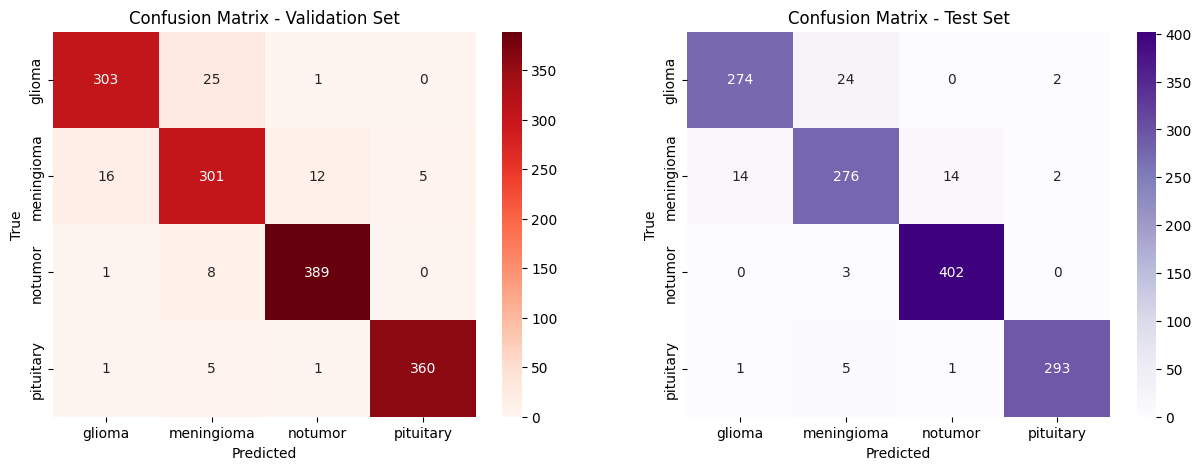

In [74]:
cm_val = confusion_matrix(y_true_val, y_pred_val)
cm_test = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Reds',
            xticklabels=full_training_and_val_dataset_transformed.classes, 
            yticklabels=full_training_and_val_dataset_transformed.classes)

plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(122)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Purples',
            xticklabels=full_test_dataset_transformed.classes, 
            yticklabels=full_test_dataset_transformed.classes)

plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

### **WNIOSKI**:
* #### Dodanie trzeciej warstwy konwolucyjnej i zastosowanie progresywnego zwiększania filtrów zwiększyło pojemność sieci, przez co model był w stanie rozpoznać trudniejsze przypadki na zbiorze testowym

# Próba piąta: zmiana funkcji aktywacji na LeakyReLU

In [76]:
img_resizer = transforms.Resize([250, 250])
img_tensor = transforms.ToTensor()

img_transformer = transforms.Compose([img_resizer, img_tensor])

full_training_and_val_dataset_transformed = datasets.ImageFolder(root=train_val_data_path, transform=img_transformer)
full_test_dataset_transformed = datasets.ImageFolder(root=test_data_path, transform=img_transformer)

img, cat = full_training_and_val_dataset_transformed[0]
print("--Training and validation dataset--")
print(f"Shape: {img.shape}; Type: {type(img)}; Category: {cat}", end="\n\n")

img, cat = full_test_dataset_transformed[0]
print("--Testing dataset--")
print(f"Shape: {img.shape}; Type: {type(img)}; Category: {cat}")

--Training and validation dataset--
Shape: torch.Size([3, 250, 250]); Type: <class 'torch.Tensor'>; Category: 0

--Testing dataset--
Shape: torch.Size([3, 250, 250]); Type: <class 'torch.Tensor'>; Category: 0


In [77]:
seed = torch.Generator().manual_seed(42)
train_data, val_data = random_split(full_training_and_val_dataset_transformed, [0.75, 0.25], generator=seed)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)  
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(full_test_dataset_transformed, batch_size=32, shuffle=False, pin_memory=True)

In [78]:
class AntiTumor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(16, 32, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),

            nn.Linear(32 * 62 * 62, 128),
            nn.LeakyReLU(),

            nn.Linear(128, 4)
            )
        
    def forward(self, x):
        return self.layers(x)

In [79]:
model = AntiTumor()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Model utilizes: {str(device).upper()}.")

model.to(device);

Model utilizes: CUDA.


In [80]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch: [1/10] | Average Loss: 0.7867.
Epoch: [2/10] | Average Loss: 0.3535.
Epoch: [3/10] | Average Loss: 0.2334.
Epoch: [4/10] | Average Loss: 0.1194.
Epoch: [5/10] | Average Loss: 0.0662.
Epoch: [6/10] | Average Loss: 0.0288.
Epoch: [7/10] | Average Loss: 0.0086.
Epoch: [8/10] | Average Loss: 0.0044.
Epoch: [9/10] | Average Loss: 0.0019.
Epoch: [10/10] | Average Loss: 0.0006.

Training completed in 0:03:18.


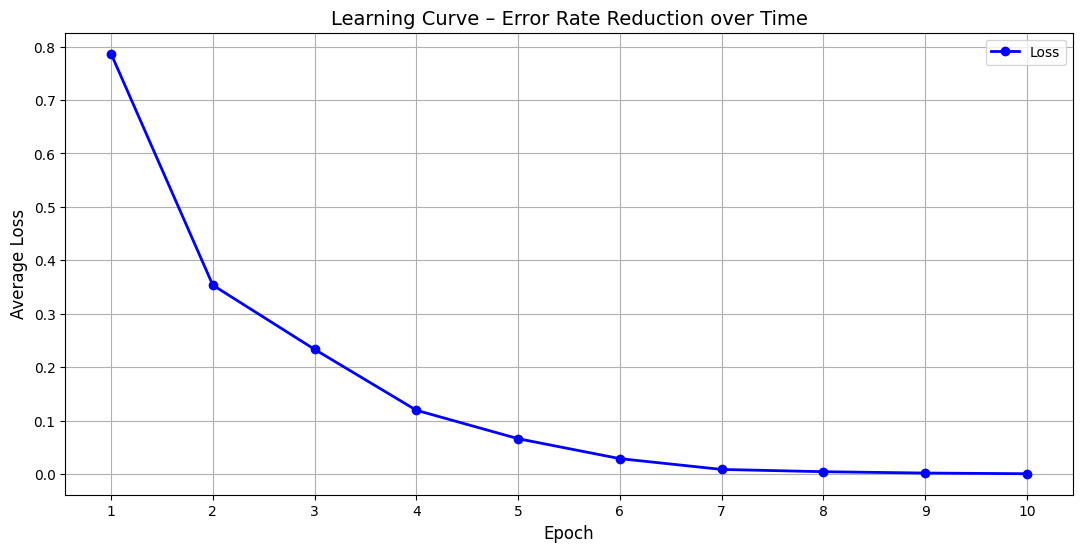

In [81]:
epochs = 10

epochs_data = [epoch for epoch in range(1, epochs+1)]
avg_loss_data = []

train_start_time = time.time()

for epoch in range(epochs):
    running_loss = 0.0
    model.train()

    for img, category in train_loader:
        img, category = img.to(device), category.to(device)

        optimizer.zero_grad()

        outputs = model(img)

        loss = loss_func(outputs, category)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    avg_loss_data.append(avg_loss)

    print(f"Epoch: [{epoch+1}/{epochs}] | Average Loss: {avg_loss:.4f}.")

if torch.cuda.is_available():
    torch.cuda.synchronize()

train_stop_time = time.time()
train_total_secodns = train_stop_time - train_start_time

print(F"\nTraining completed in {datetime.timedelta(seconds=int(train_total_secodns))}.")



plt.figure(figsize=(13, 6))

plt.plot(epochs_data, avg_loss_data, 'o-', color='blue', label='Loss', linewidth=2)

plt.title('Learning Curve – Error Rate Reduction over Time', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.xticks(epochs_data)
plt.grid(True, linestyle='-')
plt.legend()

plt.show()

In [82]:
y_true_val = []
y_pred_val = []

model.eval()

with torch.no_grad():
    for img, category in val_loader:
        img = img.to(device)

        results = model(img)
        results_list, result = torch.max(results, 1)

        y_true_val.extend(category)
        y_pred_val.extend(result.cpu().numpy())


y_true_test = []
y_pred_test = []

with torch.no_grad():
    for img, category in test_loader:
        img = img.to(device)

        results = model(img)
        results_list, result = torch.max(results, 1)

        y_true_test.extend(category)
        y_pred_test.extend(result.cpu().numpy())

print("------------------- Validation Set -------------------")
print(classification_report(y_true_val, y_pred_val, target_names=full_training_and_val_dataset_transformed.classes))

print("---------------------- Test Set ----------------------")
print(classification_report(y_true_test, y_pred_test, target_names=full_test_dataset_transformed.classes))


------------------- Validation Set -------------------
              precision    recall  f1-score   support

      glioma       0.92      0.92      0.92       329
  meningioma       0.89      0.87      0.88       334
     notumor       0.97      0.97      0.97       398
   pituitary       0.97      0.99      0.98       367

    accuracy                           0.94      1428
   macro avg       0.94      0.94      0.94      1428
weighted avg       0.94      0.94      0.94      1428

---------------------- Test Set ----------------------
              precision    recall  f1-score   support

      glioma       0.92      0.90      0.91       300
  meningioma       0.89      0.86      0.88       306
     notumor       0.96      0.99      0.97       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



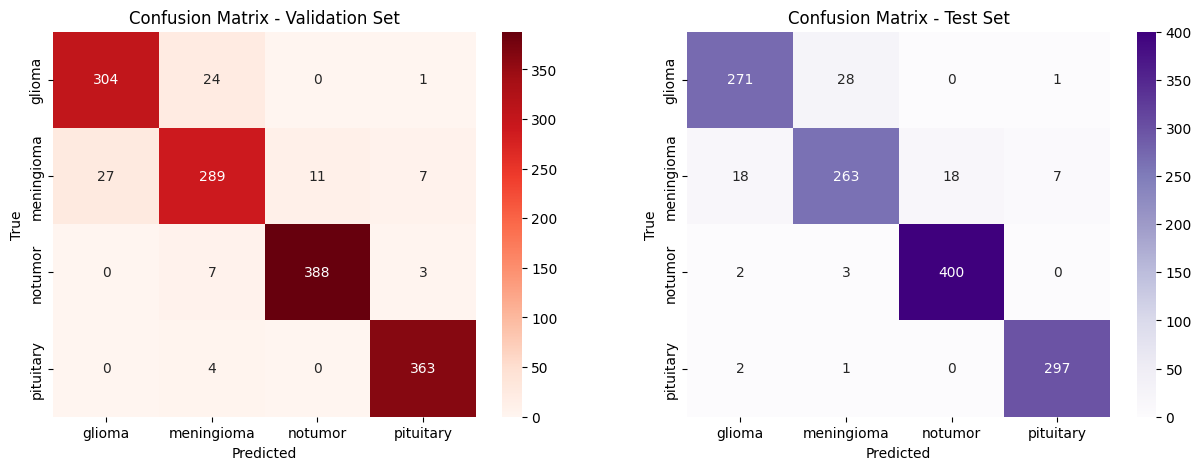

In [83]:
cm_val = confusion_matrix(y_true_val, y_pred_val)
cm_test = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Reds',
            xticklabels=full_training_and_val_dataset_transformed.classes, 
            yticklabels=full_training_and_val_dataset_transformed.classes)

plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(122)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Purples',
            xticklabels=full_test_dataset_transformed.classes, 
            yticklabels=full_test_dataset_transformed.classes)

plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

### **WNIOSKI**:
* #### Pomimo zapobieganiu wyłączania neuronów przez LeakyReLU wyniki były gorsze niż w przypadku zastosowaniu zwykłej funkcji ReLU